<a href="https://colab.research.google.com/github/badlogic/genai-workshop/blob/main/03_unsupervised_learning_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Embeddings
Text embedding models are a type of unsupervised machine learning model. They learn how to take a piece of text and transform it into a vector in what's called a latent space. This process is commonly referred to as (text) embedding.

By transforming texts into vectors, we can measure their similarity mathematically, by calculating their distances to each other in the latent space using some distance metric or similarity measure. The beauty of this approach is, that this transformation implicitely captures the meanings and semantic relations of the texts' contents. It thereby does away with many of the problems old natural language processing systems had.

This has an enormous amount of applications, both directly, and indirectly as part of bigger systems (including LLMs!).

To illustrate the power of embeddings, we are going to use a pre-trained text embedding model called `jina-embeddings-v2-base-de` from Hugging Face. The specific model can handle both English and German language texts. In fact, multi-linguality is a property of many popular text embedding models.

We will embed textual information about movies (title and description) and implement to popular "downstream" tasks for embeddings;:

1. Finding similar movies (naive recommender)
2. Finding movies that are match a user query (naive dense retrieval)

## Setup and Hugging Face login
To use the jina model, you have to:
1. Create a [Hugging Face account](https://huggingface.co/join)
2. Create an [access token](https://huggingface.co/settings/tokens)
3. Visit the [model page](https://huggingface.co/jinaai/jina-embeddings-v2-base-de) and request access.

If you run the code on your own machine, set the `HF_TOKEN` environment variable to your access token.

If you run the code here on collab, you will be prompted for your token each time you run this cell.

In [1]:
import torch
import numpy as np
from numpy.linalg import norm
from transformers import AutoModel
import umap
import matplotlib.pyplot as plt
import os

# Check if HF_TOKEN exists in the environment, otherwise fetch it from the colab
# secrets
if 'HF_TOKEN' in os.environ:
  print("Using 🤗 access token from HF_TOKEN environment variable")
else:
  from huggingface_hub import notebook_login
  notebook_login()

## Loading the embedding model

Now that we are logged in, we can use the Hugging Face `AutoModel` class download and load the model. We refer to the model via its id, which is composed of the author name and model name, e.g. `jinaai/jina-embeddings-v2-base-de`.

Alternatively, we can also point the `AutoModel` class to a local directory that contains an already downloaded model.

In [2]:
model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-de', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Convenience functions

Next, we defined a few convenience functions.

We need a way to calculate the similarity between two vectors. The `cos_sim` function allows us to do just that by calculating the [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between two vectors. A similarity of `1` means the vectors are equal, while a similiarty of `0` means they are unequal. Usually, we'll get a value between `0` and `1`.

In [3]:
cos_sim = lambda a,b: (a @ b.T) / (norm(a)*norm(b))

We also create a function called `embed_local`, which uses the locally loaded jina model to embed texts provided as parameters. You can pass a single string, or a list of strings, and will get a Numpy array, or a list of Numpy arrays back, that work with `cos_sim`.

We also have a global variable `embed` which points to the currently "active" embedding function we want to use. We can assign another function to this variable, to swap out the embedding function globally. This will come in handy later.

In [4]:
def embed_local(texts):
  return model.encode(texts)

embed = embed_local

## Movie dataset

We defined a simple dataset inline. It consists of 6 movies, each composed of the movie title and plot. These have been manually fetched from IMDB. We could of course also load such a dataset from a file or via an API. We keep things simple here.

In [5]:
movies = [
  {"title": "Star Trek: Generations", "plot": "With the help of long presumed dead Captain Kirk, Captain Picard must stop a deranged scientist willing to murder on a planetary scale in order to enter a space matrix."},
  {"title": "Star Wars: Episode V - The Empire Strikes Back", "plot": "After the Rebels are overpowered by the Empire, Luke Skywalker begins his Jedi training with Yoda, while his friends are pursued across the galaxy by Darth Vader and bounty hunter Boba Fett."},
  {"title": "Pulp Fiction", "plot": "The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption."},
  {"title": "Fight Club", "plot": "An insomniac office worker and a devil-may-care soap maker form an underground fight club that evolves into much more."},
  {"title": "Ghostbusters", "plot": "Three parapsychologists forced out of their university funding set up shop as a unique ghost removal service in New York City, attracting frightened yet skeptical customers."},
  {"title": "Ghostbusters II", "plot": "The discovery of a massive river of ectoplasm and a resurgence of spectral activity allows the staff of Ghostbusters to revive the business."},
  {"title": "The Silence of the Lambs", "plot": "In this thriller, a young F.B.I. cadet must receive the help of an incarcerated and manipulative cannibal killer to help catch another serial killer, a madman who skins his victims."},
  {"title": "Seven", "plot": "Two detectives, a rookie and a veteran, hunt a serial killer who uses the seven deadly sins as his motives."},
  {"title": "The Lord of the Rings", "plot": "A meek Hobbit from the Shire and eight companions set out on a journey to destroy the powerful One Ring and save Middle-earth from the Dark Lord Sauron."},
  {"title": "The Hobbit", "plot": "A reluctant Hobbit, Bilbo Baggins, sets out to the Lonely Mountain with a spirited group of dwarves to reclaim their mountain home, and the gold within it from the dragon Smaug."},
  {"title": "The Jungle Book", "plot": "In this classic Disney movie, Bagheera the Panther and Baloo the Bear have a difficult time trying to convince a boy to leave the jungle for human civilization."},
  {"title": "Peter Pan", "plot": "In this beautifully drawn animation film, Wendy and her brothers are whisked away to the magical world of Neverland with the hero of their stories, Peter Pan."}
]

## Creating embedding vectors for each movie
We embed both the title and plot as a single string for each movie, using the function pointed to be `embed` (which is `embed_local`).

Each vector generated by the model has a fixed length of 768 dimensions. This is a property of the jina model. Other embedding models might generate more or less dimensions.

In [6]:
embeddings = embed([movie["title"] + " " + movie["plot"] for movie in movies])
print("Dimensions of first vector: " + str(embeddings[0].shape[0]))
print("First 10 dimensions of the first vector:\n" + str(embeddings[0][:10]))
print("Dimensions of second vector: " + str(embeddings[1].shape[0]))
print("First 10 dimensions of the second vector:\n" + str(embeddings[1][:10]))

Dimensions of first vector: 768
First 10 dimensions of the first vector:
[-0.15949857 -0.2693168   0.12828872  0.03978242 -0.00434926 -0.18323022
 -0.05444287  0.08139315 -0.20358722 -0.19820127]
Dimensions of second vector: 768
First 10 dimensions of the second vector:
[-0.18870565  0.13675256 -0.12258591  0.03999804  0.00593293 -0.11011664
 -0.34029493  0.23738301 -0.23080073 -0.03576482]


Again, we can not precisely say, what each value/dimension in these vectors mean. We do however know, that they encode the meaning and semantic relationships of the original text.

## Visualizing the embeddings with UMAP
As we've seen, the jina model generates vectors with 768 dimensions. It is hard to visualize such high dimensional vector spaces in our heads.

To get a better feeling for how these vectors relate to each other, we can use another embedding model, that will reduce the dimensionality down to 2 or 3 dimensions, while trying to retain the distances between the vectors as best as possible.

One popular such model is [UMAP](https://pair-code.github.io/understanding-umap/).

Let's visualize our embedded movies in 2D and see if we can identify clusters. The `visualize_embeddings` function takes as input the embedding vectors and a label for each vector. It will embed these vectors in 2D via UMAP and plot them.


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


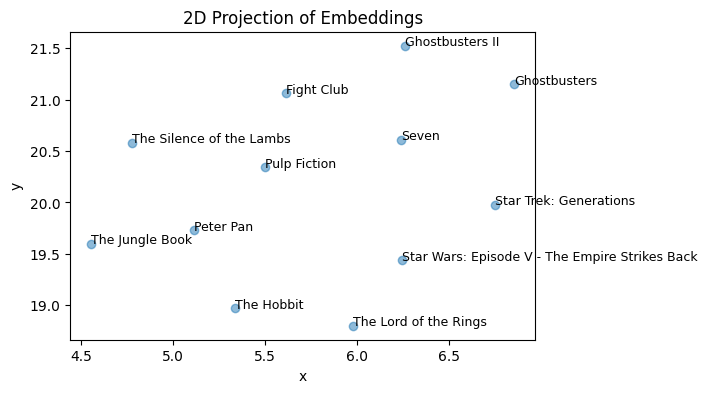

In [7]:
def visualize_embeddings(embeddings, labels):
  reducer = umap.UMAP(n_neighbors=max(15, len(embeddings) // 4), n_components=2, metric='cosine',  random_state=42)
  embeddings_2d = np.array(reducer.fit_transform(embeddings))

  plt.figure(figsize=(6, 4))
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

  for i, label in enumerate(labels):
      plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], label, fontsize=9)

  plt.title('2D Projection of Embeddings')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

visualize_embeddings(embeddings, [movie["title"] for movie in movies])

## Similarity search
We can now use those embeddings to find movies that are similar to a query. The query could be anything, like a user query, or the title and plot of another movie.

We can wrap this idea up in a function called `similarity_search`. Its parameters are as follows:

* `query`: a string or vector to find similar movies for
* `movies`: the list of movies
* `embeddings`: the list of vectors for each movie

The function first embeds the query text, if it isn't already an vector. It then calculates the cosine similarity between the query text vector and the movie vectors and stores the resulting similarity and corresponding movie in a list. Finally, the similarity list is sorted in descending order by similarity, and returned to the caller.

In [8]:
def similarity_search(query, movies, embeddings):
  query_embedding = embed(query) if isinstance(query, str) else query
  similarities = []
  for i in range(len(movies)):
    similarity = cos_sim(query_embedding, embeddings[i])
    similarities.append((movies[i], similarity))

  similarities.sort(key=lambda x: x[1], reverse=True)
  return similarities

## Naive movie recommender
Let's implement a movie recommender function. It takes as input:

* `movie`: the movie for which we want to get recommendations
* `movies`: the full list of movies (including the `movie`)
* `embeddings`: the embeddings of each movie

The function returns a list of tuples, each consisting of a movie and its similarity with the input `movie`. The list is sorted by similarity in descending order.



In [9]:
def recommend_movies(movie, movies, embeddings):
  movie_index = movies.index(movie)
  embedding = embeddings[movies.index(movie)]
  movies_to_search = [movies[i] for i in range(len(movies)) if i != movie_index]
  embeddings_to_search = [embeddings[i] for i in range(len(embeddings)) if i != movie_index]
  return similarity_search(embedding, movies_to_search, embeddings_to_search)

We can now output the list of most similar movies, for each movie

In [10]:
for i in range(len(movies)):
  print("Recommended movies for " + movies[i]["title"])
  recommended = recommend_movies(movies[i], movies, embeddings)
  for j in range(len(recommended)):
    print("\t" + recommended[j][0]["title"] + ": " + str(recommended[j][1]))
  print()

Recommended movies for Star Trek: Generations
	Star Wars: Episode V - The Empire Strikes Back: 0.25328436
	Seven: 0.2442699
	The Lord of the Rings: 0.1945294
	The Hobbit: 0.15281063
	Pulp Fiction: 0.14811614
	The Silence of the Lambs: 0.13234916
	Fight Club: 0.114247344
	Ghostbusters II: 0.10307089
	Peter Pan: 0.09382008
	Ghostbusters: 0.05439057
	The Jungle Book: 0.025979081

Recommended movies for Star Wars: Episode V - The Empire Strikes Back
	Star Trek: Generations: 0.25328436
	The Lord of the Rings: 0.20509371
	The Jungle Book: 0.13153738
	Fight Club: 0.12428885
	Peter Pan: 0.10717969
	Ghostbusters II: 0.05385293
	Pulp Fiction: 0.04211531
	The Hobbit: 0.042055022
	Seven: 0.024876125
	The Silence of the Lambs: 0.019422647
	Ghostbusters: -0.02177306

Recommended movies for Pulp Fiction
	Fight Club: 0.3838614
	The Silence of the Lambs: 0.35206327
	Seven: 0.32619292
	Peter Pan: 0.3029605
	The Jungle Book: 0.27794236
	The Hobbit: 0.19268872
	Ghostbusters II: 0.1724575
	Ghostbusters: 0.

## Naive dense retrieval
Retrieval is generally defined as finding relevant information like text, image, or audio documents for a given query. There are multiple ways to implement such retrieval systems, which are also known as "search engines". Here we'll focus on text retrieval.

Previously, a search engine had to first split up a user query into words (tokens), lower case them (normalization) and remove endings (stemming). To capture synonyms, the query terms were also expanded, in the simplest case via a synonym dictionary, so that more relevant documents could be found.

The resulting expanded query terms were then matched against an [inverted index](https://en.wikipedia.org/wiki/Inverted_index) of documents. To build the index, the documents' texts also had to go through this processing pipeline. Word positions and their resulting relationships also get entirely lost during this process. The curse of the [bag of words model](https://en.wikipedia.org/wiki/Bag-of-words_model)

To find documents matching the query, similarity measures like [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) or [BM25](https://en.wikipedia.org/wiki/Okapi_BM25) were used. These measures are actually related to the cosine similarity measure discussed above. Document representations in the invertex index are equivalent to sparse vectors, where a vector may not have an entry for each dimension of the vector space. E.g. the vector for the text "The dog is brown" only has entries for "the", "dog", "is", and "brown", but not for "house", or "car".

These sparse retrieval systems faced many challenges, with the biggest being, that they work on a word level, instead of a meaning and semantic relatedness level. They were also exceptionally hard to get working in multi-lingual settings.

"Dense retrieval" is based on vectors generated for texts by embedding models. The "dense" part stems from the fact, that the transformation does away entirely with words, and instead maps the text to semantic (albeit unobservable) concepts. We do no longer have to care for things like stemming or synonyms. These issues are automagically solved by the embedding model. These models also lend themselves well to handle multi-lingual retrieval, as semantic concepts transfer well between languages, as opposed to lexical words. The downside of dense retrieval is that exact phrase matches are not really possible. In production, sparse and dense retrieval systems are often combined, to get the best of both worlds.

Our `similarity_search` function performs dense retrieval for movie titles and plots! We've already seen how we can use dense retrieval to find similar movies for a given movie.

We can use the exact same principle to find movies that best match a user query, like those entered in a search engine. Dense retrieval simplifies implementing search engines tremendously. Let's try it out.

In the code below, we use the `similarity_search` function to find movies matching a user query, and print out the results.

In [11]:
def retrieve(query, movies, embeddings):
  results = similarity_search(query, movies, embeddings)
  print(">>> " + query)
  for i in range(len(results)):
    result = results[i]
    print(f'{result[0]["title"]}: {result[1]}')
  print()


retrieve("I want a sci-fi movie in space", movies, embeddings)
retrieve("I need a movie for children", movies, embeddings)
retrieve("I want to be scared!", movies, embeddings)

>>> I want a sci-fi movie in space
Star Trek: Generations: 0.22226382791996002
Peter Pan: 0.14958500862121582
Star Wars: Episode V - The Empire Strikes Back: 0.13036510348320007
The Jungle Book: 0.10451296716928482
The Hobbit: 0.1011020839214325
The Silence of the Lambs: 0.07244217395782471
Ghostbusters II: 0.07142180949449539
Seven: 0.03210486099123955
Ghostbusters: 0.025982193648815155
The Lord of the Rings: 0.0054916334338486195
Fight Club: 0.00512206694111228
Pulp Fiction: -0.0038630827330052853

>>> I need a movie for children
The Jungle Book: 0.3480773866176605
Peter Pan: 0.33821117877960205
The Silence of the Lambs: 0.21802964806556702
Pulp Fiction: 0.18686054646968842
Seven: 0.06618308275938034
The Hobbit: 0.06579607725143433
Star Trek: Generations: 0.045628271996974945
Ghostbusters: 0.04260002076625824
The Lord of the Rings: 0.030715836212038994
Fight Club: 0.029393216595053673
Ghostbusters II: 0.023982400074601173
Star Wars: Episode V - The Empire Strikes Back: 0.007590730674

## Deploying a model to the cloud (Hugging Face Inference Endpoints)

Running a model in a Google Colab or Jupyter notebook is fine for engineering things. Ultimately, we want to serve models for production use. This way, we do not have to provision our own (costly) hardware, such as GPU clusters, and we let someone else care about (auto-)scaling the service based on demand.

One simple way to do this is to use [Hugging Face Inference Endpoints](https://huggingface.co/inference-endpoints/dedicated).

I've deployed the jina model via Hugging Face Inference Endpoints. Once deployed, we can use this remotely running model via a simple `POST` request from anywhere. The API endpoint expects a JSON object of the form:

```
{"inputs": [first_text, second_text, ..., n_th_text], "params": {}}
```

The API endpoint returns a JSON array, where each element is an array of numbers representing the embedding vector of the corresponding input text.

We wrap this in a function called `embed_remote`, which behaves like `embed_local`, so we can swap it out in our code.

In [14]:
import requests

def embed_remote(texts):
  API_URL = "https://bkr7g18qndixix0y.eu-west-1.aws.endpoints.huggingface.cloud"
  headers = {
	  "Accept" : "application/json",
	  "Content-Type": "application/json"
  }
  if not isinstance(texts, list):
      texts = [texts]

  response = requests.post(API_URL, headers=headers, json={"inputs": texts, "payload": {}})
  response_json = response.json()
  response_np = np.array(response_json)

  if response_np.shape[0] == 1:
      return response_np[0]
  else:
      return response_np

Now let us try our dense retrieval using the remote embedding model.

In [15]:
embed = embed_remote

retrieve("I want a sci-fi movie in space", movies, embeddings)
retrieve("I need a movie for children", movies, embeddings)
retrieve("I want to be scared!", movies, embeddings)

>>> I want a sci-fi movie in space
Star Trek: Generations: 0.2221683184868855
Peter Pan: 0.1492910920658883
Star Wars: Episode V - The Empire Strikes Back: 0.13009043789302413
The Jungle Book: 0.10460892514139176
The Hobbit: 0.10134861517873282
The Silence of the Lambs: 0.07164378543254674
Ghostbusters II: 0.07101691939289406
Seven: 0.03154479420968159
Ghostbusters: 0.02626154969196028
The Lord of the Rings: 0.0054341832190696925
Fight Club: 0.005018772486957594
Pulp Fiction: -0.004303801535594148

>>> I need a movie for children
The Jungle Book: 0.34809647074531597
Peter Pan: 0.33795221605132575
The Silence of the Lambs: 0.21818881394095896
Pulp Fiction: 0.1865550377467876
Seven: 0.0662471193002756
The Hobbit: 0.06601047648030393
Star Trek: Generations: 0.04573471197802257
Ghostbusters: 0.0424232867991649
The Lord of the Rings: 0.030877109399548276
Fight Club: 0.02947681470862986
Ghostbusters II: 0.023750075602370187
Star Wars: Episode V - The Empire Strikes Back: 0.007402260364054646